In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from model_transformer import *

TensorFlow 2.x selected.
Code is built using tensorflow:2.0.0


In [2]:
%run model_transformer.py

Code is built using tensorflow:2.0.0


In [0]:
x_train, x_valid = data['train'], data['validation']

In [0]:
en_token=tfds.features.text.SubwordTextEncoder.build_from_corpus((j.numpy() for i,j in x_train),target_vocab_size=10000)
pt_token=tfds.features.text.SubwordTextEncoder.build_from_corpus((i.numpy() for i,j in x_train),target_vocab_size=10000)

In [0]:
def add_start_end_token(pt,en):
    return [pt_token.vocab_size]+pt_token.encode(pt.numpy())+[pt_token.vocab_size+1],[en_token.vocab_size]+en_token.encode(en.numpy())+[en_token.vocab_size+1]
           
def encode(pt,en):
    return tf.py_function(add_start_end_token,[pt,en],Tout=[tf.int64,tf.int64])

def filter_sequences_length(pt,en,max_sequence_length=30):
    return tf.math.logical_and(tf.shape(pt)[0]<=max_sequence_length,tf.shape(en)[0]<=max_sequence_length)

batch_size=32
x_train=x_train.map(encode).filter(filter_sequences_length).cache().shuffle(30000).padded_batch(batch_size,padded_shapes=([-1], [-1])).prefetch(tf.data.experimental.AUTOTUNE)
x_valid=x_valid.map(encode).filter(filter_sequences_length).padded_batch(batch_size,padded_shapes=([-1], [-1]))

In [0]:
path="./nmt/train/"
ckpt=tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)
ckpt_manage=tf.train.CheckpointManager(checkpoint=ckpt,directory=path,max_to_keep=4)
if ckpt_manage.latest_checkpoint:
    ckpt.restore(ckpt_manage.latest_checkpoint)
    

In [7]:
epochs=30 #should be at-least 100 epochs for getting good results because of less learning rate

for ii in range(epochs):
    train_loss.reset_states();train_accuracy.reset_states()
    
    for (batch,(inp,target)) in enumerate(x_train):
        
        
        if batch ==0 and ii==0:
          with tf.device("/gpu:0"):
            train(inp,target,True)
        else:
          with tf.device("/gpu:0"):
            train(inp,target,False)
        
        if batch % 200 == 0:
              print (' For epoch {}, batch {}  the loss is  {:.4f} Accuracy {:.4f}'.format(ii + 1, batch, train_loss.result(), train_accuracy.result()))
    
    if (ii + 1) % 2 == 0:
        ckpt_save = ckpt_manage.save()
        print ('Saving checkpoint for epoch {} at {}'.format(ii+1,
                                                         ckpt_save))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(ii + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))



Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_nx_1 (encoder_nx)    multiple                  5731748   
_________________________________________________________________
decoder_nx_1 (decoder_nx)    multiple                  7173848   
_________________________________________________________________
dense_129 (Dense)            multiple                  3055150   
Total params: 15,960,746
Trainable params: 15,960,746
Non-trainable params: 0
_________________________________________________________________
None
Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_nx_1 (encoder_nx)    multiple                  5731748   
_________________________________________________________________
decoder_nx_1 (decoder_nx)    multiple                  7173848   
_____________

In [0]:
def get_output(encoder_input):
    start_token =[pt_token.vocab_size]
    end_token=[pt_token.vocab_size+1]
    encoder_input=start_token+pt_token.encode(encoder_input)+end_token
    encoder_input=tf.expand_dims(encoder_input,0) 
    decoder_input=tf.expand_dims([en_token.vocab_size],0)
    
    for _ in range(30): #30 is the max-length till which we trained the decoder and want the<end> token to be predicted in those 30 sequences
        encoder_mask,decoder_look_ahead=create_mask(encoder_input,decoder_input)
        output,attn_dict=transformer(encoder_input,decoder_input,encoder_mask,decoder_look_ahead,True)
        output=tf.cast(tf.argmax(output[:,-1,:],axis=-1),tf.int32)
        if output==en_token.vocab_size+1:
            return tf.squeeze(decoder_input,axis=0),attn_dict
        
        
        decoder_input=tf.concat([decoder_input,tf.expand_dims(output,0)],axis=-1)
    return tf.squeeze(decoder_input,axis=0),attn_dict

In [33]:
sample='como vai você ?'
eng,attn_dict_sample=get_output(sample)
out=''
for i in eng:
    if i<en_token.vocab_size:
        out+=en_token.decode([i])
        out+=' '
out

'how  about  it  ? '

In [19]:
sample='eu sou do'
eng,attn_dict_sample=get_output(sample)
out=''
for i in eng:
    if i<en_token.vocab_size:
        out+=en_token.decode([i])
        out+=' '
out

'i  am  a  friday  . '

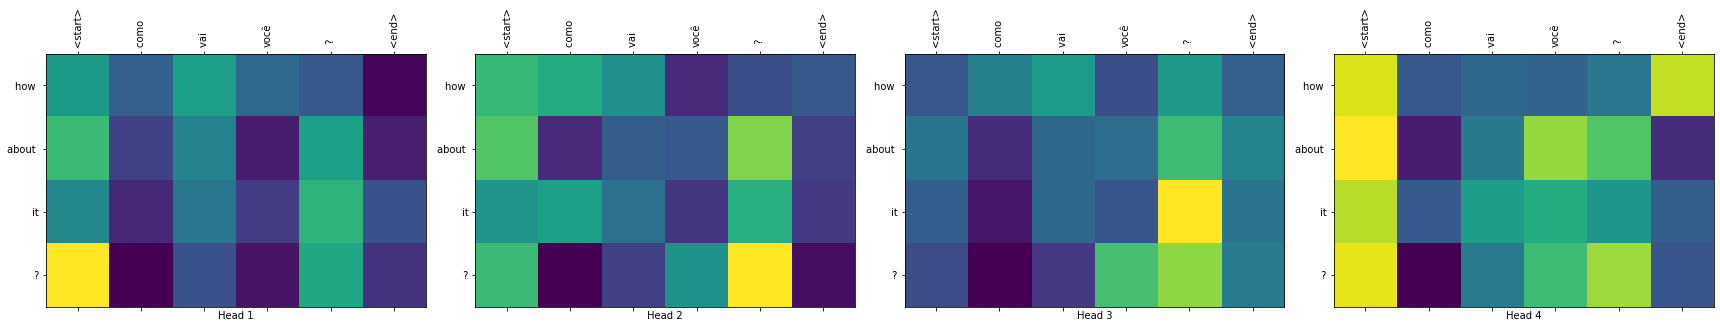